# Marijuana Sales in Denver
http://github.com/weinerjm/data-world

Data downloaded from https://data.world/denver/marijuana-gross-sales and https://data.world/denver/marijuana-related-crime .

Start with the usual imports. I'm using `Python 2.7.13` for this analysis.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import calendar
from pprint import pprint
%matplotlib inline

Import the gross sales data and generate some useful features like:
1. The month number from the month name (e.g., 'September' -> 9)
2. A cleaned-up month name (titleized e.g., `SEPTEMBER` -> `September`)
3. A `datetime` column constructed from the year and month (for easier math and plotting)
4. `medical` and `retail` DataFrames, corresponding to medical or retail sales entries.
5. Convert the sales from USD to millions of USD.

In [2]:
sales = pd.read_csv('marijuana_gross_sales.csv')

month_num = {calendar.month_name[i].upper(): i for i in range(1,13)}
sales['MONTH_NAME'] = sales['MONTH'].str.strip().str.title()
sales['MONTH'] = sales['MONTH'].str.strip().replace(month_num)
sales['GROSS_SALES'] /= 1e6
sales['DATE'] = pd.to_datetime(sales['MONTH_NAME'].str.cat(sales['YEAR'].astype(str)),
                              format='%B%Y')

medical = sales[sales['GROSS_SALES_TYPE'] == 'Medical Total Gross Sales']
retail = sales[sales['GROSS_SALES_TYPE'] == 'Retail Total Gross Sales']
sales.head(10)

,YEAR,MONTH,GROSS_SALES_TYPE,GROSS_SALES,MONTH_NAME,DATE
0,2016,9,Retail Total Gross Sales,NaN,September,2016-09-01
1,2016,9,Medical Total Gross Sales,NaN,September,2016-09-01
2,2016,8,Medical Total Gross Sales,NaN,August,2016-08-01
3,2016,8,Retail Total Gross Sales,NaN,August,2016-08-01
4,2016,7,Retail Total Gross Sales,NaN,July,2016-07-01
5,2016,7,Medical Total Gross Sales,NaN,July,2016-07-01
6,2016,6,Retail Total Gross Sales,21.808308,June,2016-06-01
7,2016,6,Medical Total Gross Sales,18.451945,June,2016-06-01
8,2016,5,Medical Total Gross Sales,18.139726,May,2016-05-01
9,2016,5,Retail Total Gross Sales,21.767245,May,2016-05-01


What do the retail sales look like as a function of time in each year?

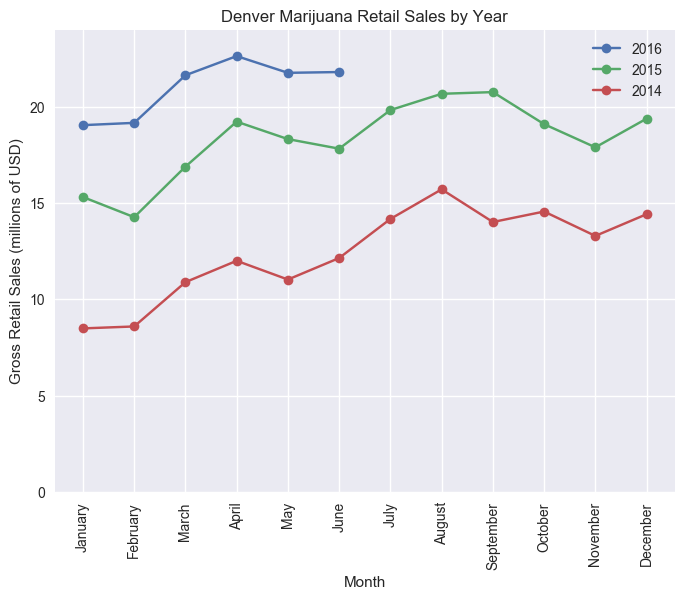

In [3]:
fig = plt.figure(figsize=(8,6))
for year in retail['YEAR'].unique():
    curr_year = (retail['YEAR'] == year)
    plt.plot(retail[curr_year]['MONTH'],
            retail[curr_year]['GROSS_SALES'],
            linestyle='-', marker='o')
plt.legend([year for year in retail['YEAR'].unique()])
plt.xticks(range(1,13), rotation='vertical')
plt.xlabel('Month')
plt.ylim((0,24))
plt.ylabel("Gross Retail Sales (millions of USD)")
ax = plt.gca()
labels = [item for item in plt.xticks()[0]]
plt.title("Denver Marijuana Retail Sales by Year")
ax.set_xticklabels([calendar.month_name[int(i)] for i in labels]);

Interestingly, the sales are increasing steadily by year. It looks like there was a bigger fractional increase from 2014-2015 than from 2015-2016. It might be interesting to normalize to sales per capita (I know for a fact that Denver's population is growing at a high rate) instead of looking at the gross revenue.

It looks like we can notice some patterns of months with higher sales, but is it just noise? 

Let's see if we can better quantify the apparent excess in sales for certain months. First, we'll visualize all the sales as a function of time.

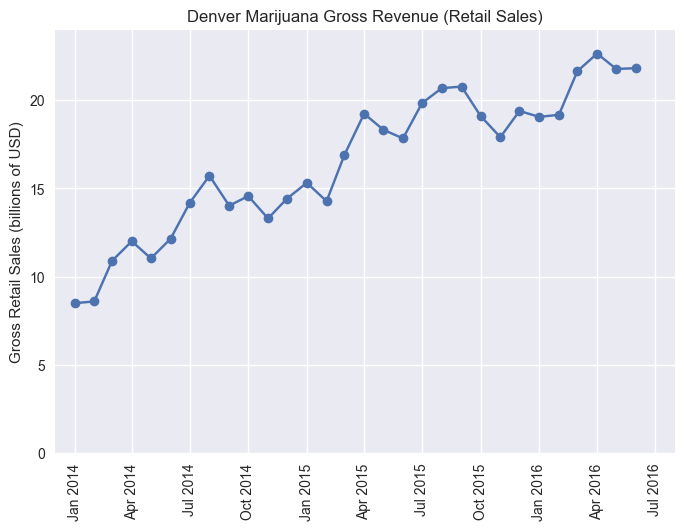

In [4]:
import matplotlib.dates as mdates

plt.plot(retail['DATE'], 
         retail['GROSS_SALES'],
         marker='o')
plt.xlim(pd.to_datetime('December 2013'),
        pd.to_datetime('August 2016'))
plt.xticks(rotation='vertical')
abs_months = plt.xticks()[0].copy()

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax.tick_params(axis='x',which='minor',bottom='on')
plt.gca().xaxis.set_minor_locator(mdates.MonthLocator(interval=1))

plt.ylim((0,24))
plt.ylabel('Gross Retail Sales (billions of USD)')
plt.title('Denver Marijuana Gross Revenue (Retail Sales)');

Let's take out the overall increase in sales so that we can get a good estimate of the fractional deviation. 

It almost looks like a linear fit would work well. Would a small higher-order (second-order) correction fit the data better though? You might expect that the second-order effect is a slight saturation effect (we could probably check this later by looking at the marijuana business license data from http://data.world).

We'll do a linear fit and a quadratic fit, then check the reduced $\chi^2$.

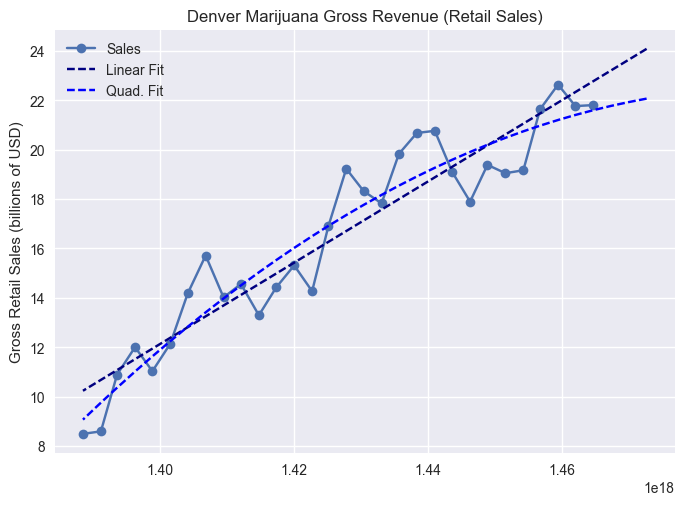

In [5]:
import scipy.stats
mask = pd.notnull(retail['DATE']) & pd.notnull(retail['GROSS_SALES']) # fit mask to take out NaNs
fit_x = retail['DATE'].astype(np.int64)
plin, residl, _, _, _ = np.polyfit(fit_x[mask], retail['GROSS_SALES'][mask],
                                     1, full=True)

pquad, residq, _, _, _ = np.polyfit(fit_x[mask], retail['GROSS_SALES'][mask],
                                                        2, full=True)
quadfit = np.poly1d(pquad)
linfit = np.poly1d(plin)
plt.plot(fit_x, retail['GROSS_SALES'], marker='o')
plt.plot(fit_x, linfit(fit_x), color='Navy',linestyle='--')
plt.plot(fit_x, quadfit(fit_x), color='Blue', linestyle='--')
plt.ylabel('Gross Retail Sales (billions of USD)')
plt.title('Denver Marijuana Gross Revenue (Retail Sales)')
plt.legend(['Sales','Linear Fit','Quad. Fit']);

It's hard to tell from the plot above which fit is better. Let's just look at the residuals.

Quadratic Fit reduced sum squared residuals: 0.00575284979517
Linear Fit reduced sum squared residuals: 0.0075635215049


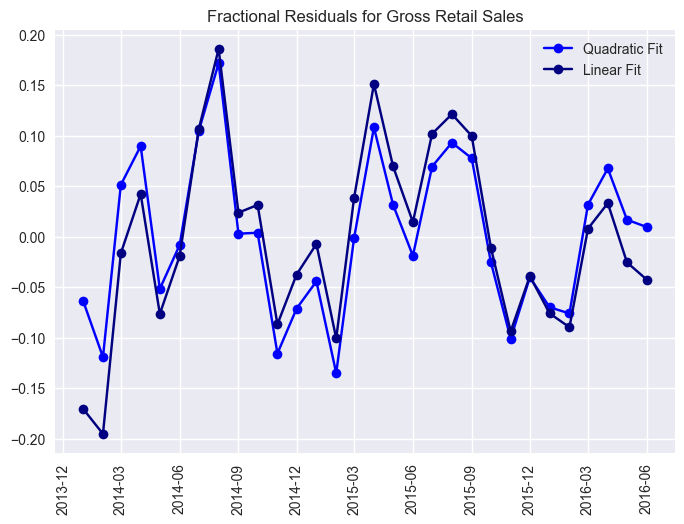

In [6]:
def calc_residuals(x, y, fit_func): 
    """Calculate the fractional residuals."""
    return (y - fit_func(x)) / fit_func(x)

resid_quad = calc_residuals(fit_x, retail['GROSS_SALES'], quadfit)
resid_lin = calc_residuals(fit_x, retail['GROSS_SALES'], linfit)

plt.plot(retail['DATE'],resid_quad, marker='o', color='blue')
plt.plot(retail['DATE'],resid_lin, marker='o', color='Navy')
plt.title('Fractional Residuals for Gross Retail Sales')
plt.legend(['Quadratic Fit', 'Linear Fit'])
print "Quadratic Fit reduced sum squared residuals: {}".format(np.sum(np.power(resid_quad, 2)) / (resid_quad.shape[0] - 3))
print "Linear Fit reduced sum squared residuals: {}".format(np.sum(np.power(resid_lin, 2)) / (resid_lin.shape[0] - 2))
plt.xticks(rotation='vertical');

So it looks like the quadratic fit is slightly better even when accounting for the difference in degrees of freedom.

Let's use this to find some patterns. Initially I thought I saw some peaks in the data at certain months: April and August.

What's significant about these months? Well, aside from being the start of spring, April 20 is in April. Also, August corresponds to the return of students to most Colorado universities and colleges.

What's the fractional deviation in sales in those months?

In [7]:
def extract_month_residuals(months):
    month_x = pd.to_datetime(months)
    month_ind = retail['DATE'].apply(lambda x: x in month_x)
    month_sales = retail[month_ind]['GROSS_SALES'].values[::-1] # needed to reverse to match up the y, fit(x) values.
    month_resid = calc_residuals(month_x.astype(np.int64), month_sales, quadfit)
    pprint(zip(months, month_resid))
    return month_resid

aprils = ['April 2014', 'April 2015', 'April 2016']
april_resid = extract_month_residuals(aprils)

print "Mean: {:.2f}, Std. Dev.: {:.2f}".format(np.mean(april_resid), np.std(april_resid, ddof=1))

[('April 2014', 0.089705794332305105),
 ('April 2015', 0.10812528330372306),
 ('April 2016', 0.067569908619846006)]
Mean: 0.09, Std. Dev.: 0.02


The number of Aprils we have data for is low, but the result seems like it could be significant: higher sales in April by almost 10% (give or take a couple percent).

Let's try the same thing for August:

In [8]:
augusts = ['August 2014', 'August 2015', 'August 2016']
august_resid = extract_month_residuals(augusts)
print august_resid[~np.isnan(august_resid)].mean()
print "Mean: {:.2f}, Std. Dev.: {:.2f}".format(august_resid[~np.isnan(august_resid)].mean(), 
                                               august_resid[~np.isnan(august_resid)].std(ddof=1))

[('August 2014', 0.171749174517837),
 ('August 2015', 0.093122012070978116),
 ('August 2016', nan)]
0.132435593294
Mean: 0.13, Std. Dev.: 0.06


Okay, we only have two points, but it is pretty suggestive that Augusts tend to have a little more than 10% extra sales.

It would also be fun to look at more fine-grained annual data, fit away the overall increase, and do Fourier analysis to pick out the annual patterns. Just need more data!

# Relationship between Marijuana Sales and Marijuana-related Crime

First, import the data. https://data.world/denver/marijuana-related-crime

In [9]:
crime = pd.read_csv('crime_marijuana.csv')
crime.head()

,INCIDENT_ID,FIRST_OCCURENCE_DATE,LAST_OCCURENCE_DATE,REPORTDATE,INCIDENT_ADDRESS,GEO_X,GEO_Y,DISTRICT_ID,PRECINCT_ID,OFFENSE_CODE,OFFENSE_TYPE_ID,OFFENSE_CATEGORY_ID,MJ_RELATION_TYPE,NEIGHBORHOOD_ID
0,201279583,27-FEB-12,27-FEB-12,27-FEB-12,5702 E COLFAX AVE,3162682.0,1694930.0,2,222,2203,BURGLARY - BUSINESS BY FORCE,Burglary,INDUSTRY\r,montclair
1,2012355975,06-AUG-12,06-AUG-12,06-AUG-12,3054 LARIMER ST,3146378.0,1703160.0,2,211,2203,BURGLARY - BUSINESS BY FORCE,Burglary,INDUSTRY\r,five-points
2,2012433617,18-SEP-12,18-SEP-12,18-SEP-12,9206 E HAMPDEN AVE,3174408.0,1662984.0,3,323,2203,BURGLARY - BUSINESS BY FORCE,Burglary,INDUSTRY\r,hampden-south
3,2012378437,18-AUG-12,18-AUG-12,19-AUG-12,5403 N BILLINGS ST,3189349.0,1714135.0,5,512,5707,CRIMINAL TRESPASSING,All Other Crimes,NON-INDUSTRY\r,montbello
4,2012541015,21-NOV-12,21-NOV-12,21-NOV-12,82 S FEDERAL BLVD,3133690.0,1685664.0,4,411,2203,BURGLARY - BUSINESS BY FORCE,Burglary,INDUSTRY\r,valverde


Let's aggregate the number of all marijuana-related crimes by month and plot versus time.

We can also do some exponential averaging to smooth out the curve a little bit, which makes it easier to read the plot.

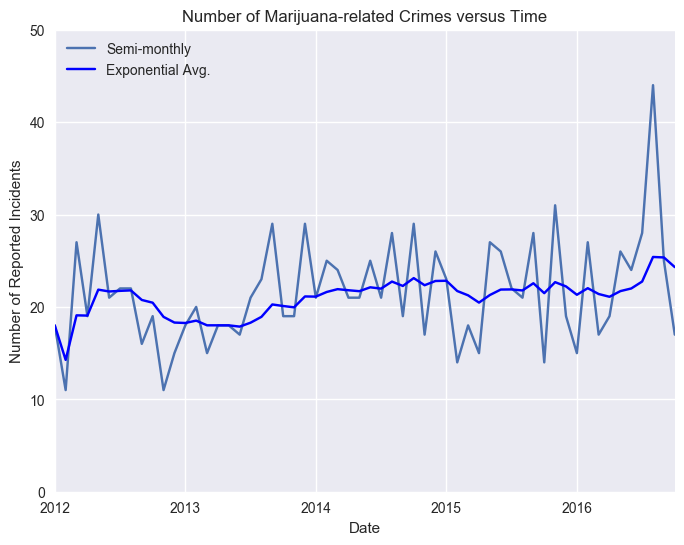

In [10]:
fig = plt.figure(figsize=(8,6))
crime['DATE'] = pd.to_datetime(crime.FIRST_OCCURENCE_DATE.str.title(),
                                      format='%d-%b-%y')
# freq: SM is semi-monthly
# M is monthly
by_month = crime.groupby(pd.Grouper(key='DATE', freq='M')).size() 
by_month_roll = by_month.rolling(5, center=False).mean()
by_month_smth = by_month.ewm(span=15).mean()
by_month.plot()
by_month_smth.plot(style='b')
plt.ylim(0,50)
plt.xlabel('Date')
plt.ylabel('Number of Reported Incidents')
plt.title('Number of Marijuana-related Crimes versus Time')
plt.legend(['Semi-monthly','Exponential Avg.','Rolling Avg.'],loc='upper left');

Let's plot both the gross retail sales and number of marijuana-related crimes over the years.

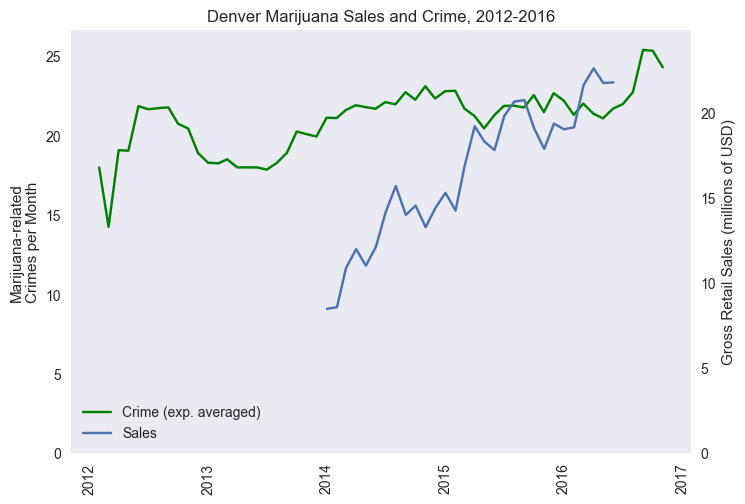

In [11]:
import matplotlib.dates as mdates
plt.figure(figsize=(8,6))
fig, ax = plt.subplots()

plt.title('Denver Marijuana Sales and Crime, 2012-2016')
plt.xticks(rotation='vertical')
line = ax.plot(by_month_smth, c='g',
              linestyle='-', label='Expon. Smoothing')
ax.set_ylabel('Marijuana-related\nCrimes per Month')
ax.set_ylim(0,by_month_smth.max()*1.05)
ax.legend(loc=0)

ax_r = ax.twinx() 
line_r = ax_r.plot(retail['DATE'], 
         retail['GROSS_SALES'],
         marker=None, label='By Month')
ax_r.set_ylabel('Gross Retail Sales (millions of USD)')
ax_r.set_ylim(0, retail['GROSS_SALES'].max()*1.1)

lns = line+line_r
labs = ['Crime (exp. averaged)','Sales']
ax.legend(lns, labs, loc='lower left')

ax.grid(False)
ax_r.grid(False);

Maybe there's a little increase in marijuana-related crimes after legalization. But just looking at the plot, nothing compelling jumps out.

# Crimes by Neighborhood
How about total number of crimes by neighborhood?

I found it interesting that the neighborhoods/districts listed in this dataset are not used on sites like Zillow for house pricing. I hadn't seen a lot of these names before, especially the small distinctions in the RiNo/Five Points/LoDo areas (look up the names here on Google).

In [12]:
by_month_df = pd.DataFrame(by_month, columns=['Counts'])
by_month_df['DATE'] = by_month_df.index

In [13]:
nbhd_dict = dict(zip(crime['NEIGHBORHOOD_ID'].unique(), 
                     range(len(crime['NEIGHBORHOOD_ID']))))
num_to_nbhd = {v: k for k,v in nbhd_dict.iteritems()}

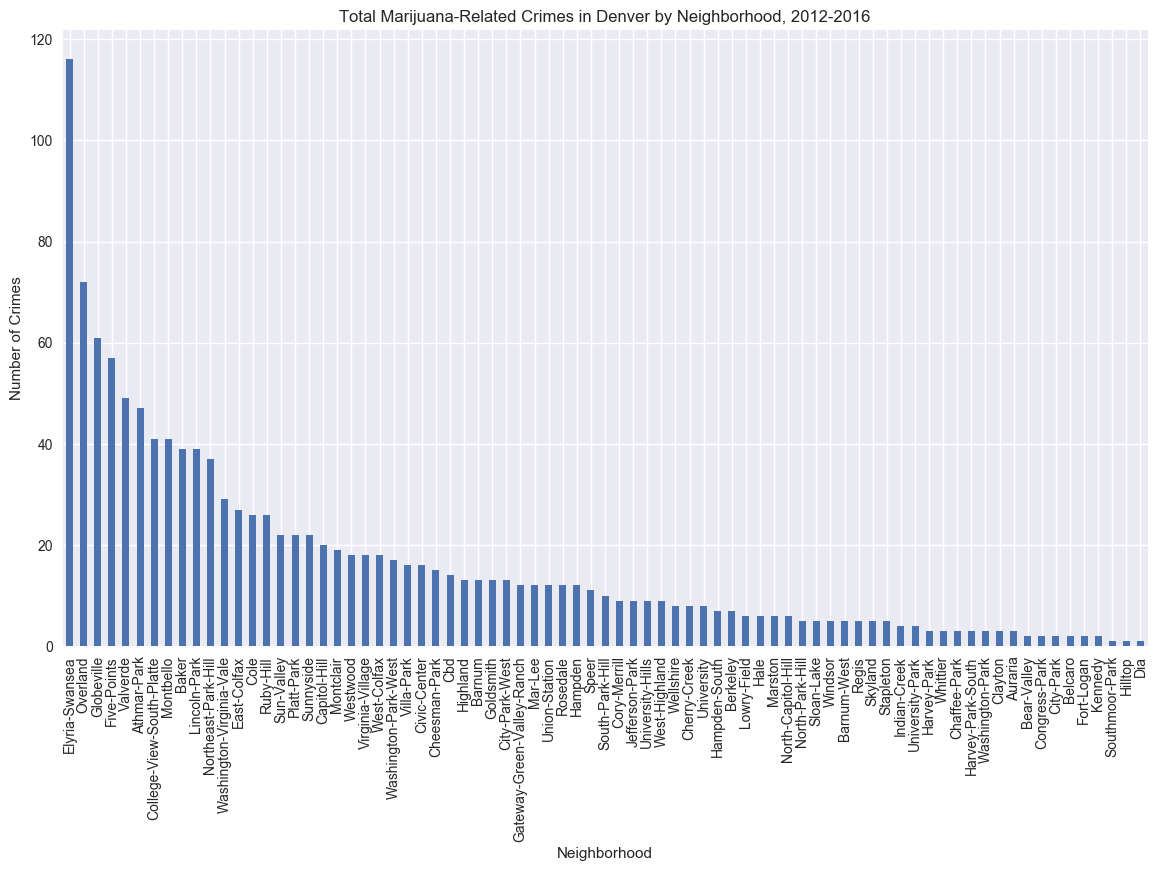

In [14]:
plt.figure(figsize=(14,8));
to_plot = crime['NEIGHBORHOOD_ID'].value_counts().sort_values(ascending=False)
ax =to_plot.plot(kind='bar')
ax.set_xticklabels([lbl.get_text().title() for lbl in ax.get_xticklabels()])
plt.xlabel('Neighborhood')
plt.ylabel('Number of Crimes')
plt.title('Total Marijuana-Related Crimes in Denver by Neighborhood, 2012-2016');

That's a lot of geographical districts. What are the top 5 and bottom 5?

In [15]:
to_plot.index = to_plot.index.str.title()
print to_plot.head(5)
print ""
print to_plot.tail(5)

Elyria-Swansea    116
Overland           72
Globeville         61
Five-Points        57
Valverde           49
Name: NEIGHBORHOOD_ID, dtype: int64

Fort-Logan        2
Kennedy           2
Southmoor-Park    1
Hilltop           1
Dia               1
Name: NEIGHBORHOOD_ID, dtype: int64


## Thanks
Thanks for reading to the end. I plan on using some more free time to update this notebook as I come up with better ideas. 

I hope this inspires you to do your own analysis. Let's compare notes!